In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from skimage.color import gray2rgb
from NOMADS_postproc import postproc
from matplotlib import pyplot as plt
from Quality import make_overlap_img

# Import Algorithm and Data Handler (from rapidalg)

In [3]:
from NOMADS_beta import NomadsBeta
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
from data_handler import load_and_preproc, get_train_set

## Load And Preprocess Data
- Z-Transform within slice

In [4]:
data = load_and_preproc('./data/rorb_data.data', True)
biomarker_list = ['PSD95', 'synapsin', 'Gephyrin', 'VGlut1', 'GABA', 'GAD2', 'GluN1']
train_data = {}
test_data = {}
for key in biomarker_list + ['annotation']:
    vol = data[key]
    train_data[key] = vol[vol.shape[0]//2:, :, :]
    test_data[key] = vol[:vol.shape[0]//2, :, :]

## Make Train Set
- Method get_train_set included in Data Handler
    - Any Shape Volume
    - Any Num Channels
    - Any Class Balance Ratio

In [5]:
train_features, train_labels = get_train_set(train_data, 8, 1, biomarker_list, balance=True, positive_to_negative_ratio=1/1.5)
test_features, test_labels = get_train_set(test_data, 8, 1, biomarker_list, balance=True, positive_to_negative_ratio=1/1.5)

## Make NomadsBeta Model & Run Training

In [6]:
model = NomadsBeta(len(biomarker_list),
                   learning_rate = 1e-4,
                   decay=0.005)

In [ ]:

batch_size = 512 
epochs = 5
losses = []
f1s = []

for epoch in range(epochs):
    #50 Iterations for sake of Demo
    for iteration, batch_start_idx in enumerate(range(0, len(train_features), batch_size)):
        batch_features = np.stack(train_features[batch_start_idx:batch_start_idx+batch_size])
        batch_labels = np.stack(train_labels[batch_start_idx:batch_start_idx+batch_size])
        if not iteration % 2:
            batch_pretrain_pred = model.predict_on_batch(batch_features)
            tp = 0
            fp = 0
            fn = 0
            for i in range(len(batch_labels)):
                if np.argmax(batch_pretrain_pred[i]) == np.argmax(batch_labels[i]):
                    if np.argmax(batch_labels[i]):
                        tp +=1
                else:
                    if np.argmax(batch_labels[i]):
                        fn +=1
                    else:
                        fp +=1

            prec = tp/(tp+fp+1)
            rec = tp/(tp+fn+1)
            f1 = 2*prec*rec/(prec+rec+1)
            f1s.append(f1)
        print("got here")
        cur_loss = model.train_on_batch(batch_features, batch_labels)
        losses.append(cur_loss)
    print("got here")

got here
got here


In [7]:

loaded_model = NomadsBeta(len(biomarker_list),
                          learning_rate = 1e-4,
                          decay=.0005,
                          checkpoint='./data/model.h5')

#loaded_model = model

# Evaluate on Test Set

In [7]:
test_set_predictions = loaded_model.predict_on_batch(np.stack(test_features))

In [8]:
tp = 0
fp = 0
fn = 0
for i in range(len(test_set_predictions)):
    if np.argmax(test_set_predictions[i]) == np.argmax(test_labels[i]):
        if np.argmax(test_labels[i]):
            tp +=1
    else:
        if np.argmax(test_labels[i]):
            fn +=1
        else:
            fp +=1

In [9]:
prec = tp/(tp+fp)
rec = tp/(tp+fn)
print('Prec: ', prec)
print('Rec: ', rec)
print('F1: ', 2*prec*rec/(prec+rec))

Prec:  0.7094329028635598
Rec:  0.6530559503811862
F1:  0.6800780461548813


# Collman Plot

In [8]:
full_data = np.stack([test_data[biomarker] for biomarker in biomarker_list])
full_data = np.moveaxis(full_data, 0, -1)
print(full_data.shape)

(19, 136, 143, 7)


In [9]:
radius = 8
full_gt = test_data['annotation']
full_gt = full_gt[1:-2, radius:-radius-1, radius:-radius-1]

In [10]:
full_predictions = np.zeros(full_data.shape[:-1])
for z in tqdm(range(1, full_data.shape[0]-2)):
    for y in range(radius, full_data.shape[1]-radius-1):
        for x in range(radius, full_data.shape[2]-radius-1):
            window = full_data[z-1:z+2, y-radius:y+radius, x-radius:x+radius, :]
            prediction = np.squeeze(loaded_model.predict_on_batch(np.stack([window])))
            if np.argmax(prediction):
                full_predictions[z, y, x] = 1

100%|██████████| 16/16 [08:39<00:00, 32.46s/it]


In [11]:
full_predictions = full_predictions[1: -2, radius:-radius-1, radius:-radius-1]
full_predictions.shape

(16, 119, 126)

In [12]:
full_postproc = np.stack([postproc(elem, 10) for elem in full_predictions])

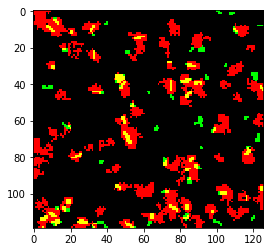

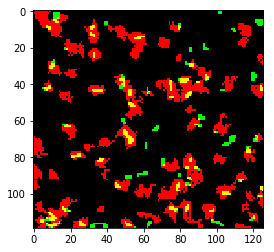

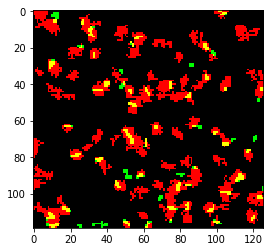

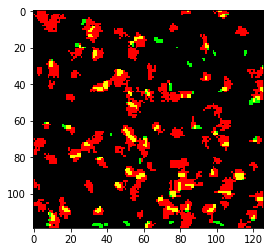

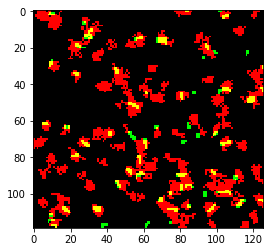

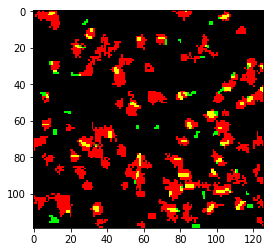

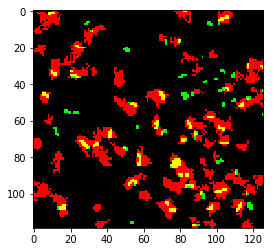

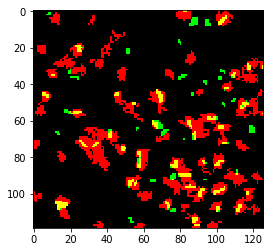

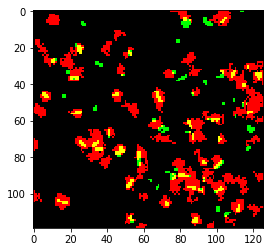

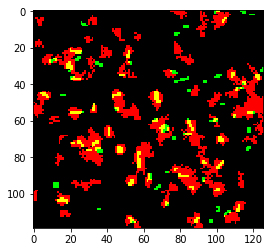

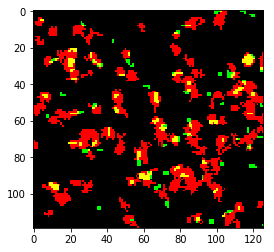

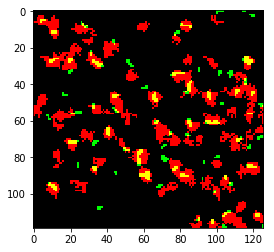

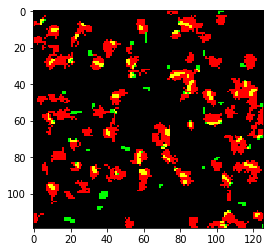

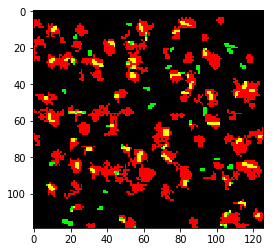

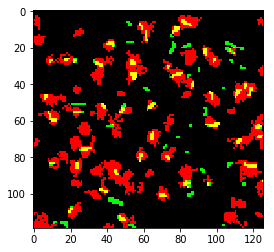

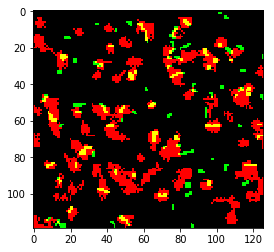

In [15]:
for idx, z_postproc in enumerate(full_postproc):
    plt.figure()
    img = make_overlap_img(z_postproc, full_gt[idx])
    plt.imshow(img)
    plt.show()

In [16]:
from skimage.measure import label
def get_b_per_a(a=None, b=None, disp=False):
    l_a = label(a > 0)
    l_b = label(b > 0)
    counts = []
    for a_idx in np.unique(l_a):
        #dont count background
        if a_idx != 0:
            rel_locs = [elem for elem in zip(*(np.where(l_a == a_idx)))]
            uniques = np.unique([l_b[elem] for elem in rel_locs])
            if disp:
                print(a_idx, '\t', uniques)
            count = len(uniques)
            
            if 0 in uniques:
                count -=1
            counts.append(count)
    return counts

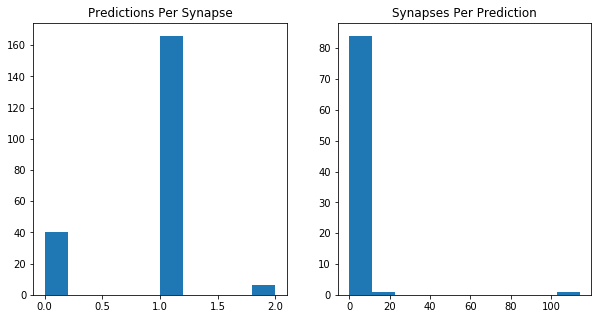

In [17]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.set_title('Predictions Per Synapse')
dist = []
dist = get_b_per_a(a=full_gt[1:-2] > 0, b=full_postproc[1:-2] > 0)
plt.hist(dist)
ax = plt.subplot(122)
ax.set_title('Synapses Per Prediction')
dist = get_b_per_a(b=full_gt[1:-2] > 0, a=full_postproc[1:-2] > 0)
plt.hist(dist)
plt.show()

In [18]:
print(test_set_predictions)

[[0.37268317 0.62731683]
 [0.6934263  0.30657378]
 [0.6321196  0.36788043]
 ...
 [0.2941834  0.7058166 ]
 [0.3349634  0.6650366 ]
 [0.27001783 0.72998214]]


In [19]:
print(test_set_predictions.shape)

(19347, 2)


In [20]:
print(test_labels)

[[False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [False, True], [True, False], [False, True], [False, True], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [False, True], [False, True], [True, False], [False, True], [True, False], [False, True], [False, True], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [False, True], [False, True], [True, False], [True, Fa

In [21]:
print(full_postproc)

[[[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False  True  True ... False False False]
  [ True  True  True ... False False False]
  [False  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [13]:
from skimage import measure
from skimage import filters

In [14]:
import numpy as np

In [29]:
synapse_labels = measure.label(full_postproc, background=0)

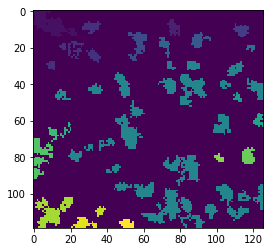

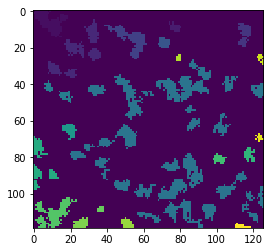

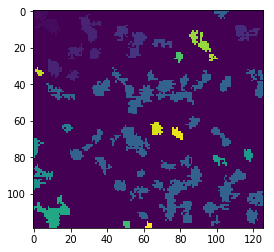

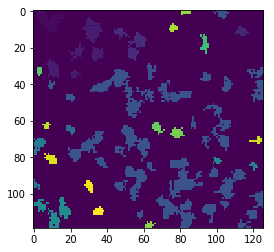

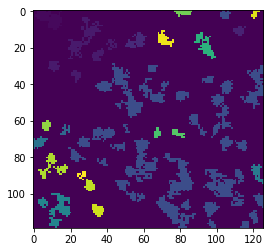

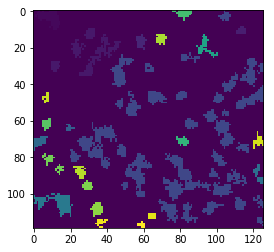

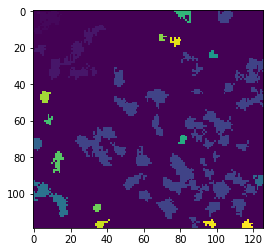

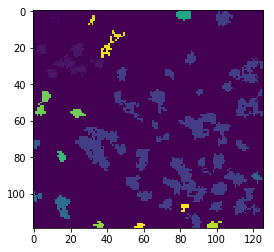

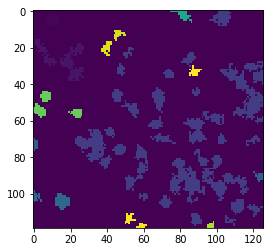

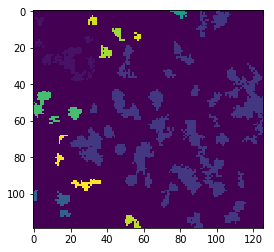

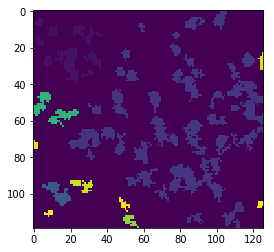

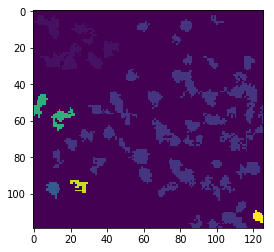

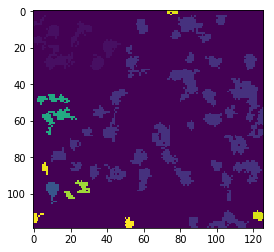

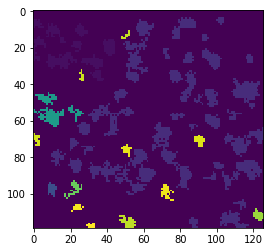

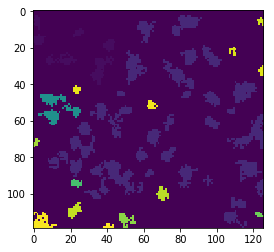

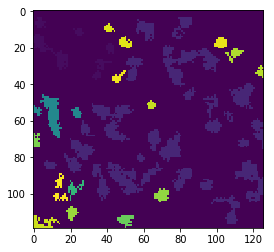

In [30]:
for i in range(synapse_labels.shape[0]):
    plt.figure()
    plt.imshow(synapse_labels[i])
    plt.show()

In [33]:
print(np.unique(synapse_labels))


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92 200]


In [21]:
test = synapse_labels[0]
print(test[0][0])
print(np.unique(test))

1
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22 200]


In [22]:
connected_components = {}
for y in range(test.shape[0]):
    for x in range(test.shape[1]):
        if (test[y][x] in connected_components.keys()):
            connected_components[test[y][x]].append((y, x))
        else:
            connected_components[test[y][x]] = [(y, x)]

print(connected_components.keys())
connected_components.pop(0)

dict_keys([1, 0, 2, 3, 4, 200, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])


[(0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101),
 (0, 102),
 (0, 103),
 (0, 104),
 (0, 105),
 (0, 106),
 (0, 107),
 (0, 108),
 

In [23]:
synapse_centroids = []
for key, value in connected_components.items():
    y, x = zip(*value)
    synapse_centroids.append((int(sum(y)/len(y)), int(sum(x)/len(x))))

In [24]:
print(synapse_centroids)

[(7, 9), (9, 76), (18, 25), (10, 113), (58, 71), (18, 56), (16, 90), (18, 71), (20, 118), (29, 74), (75, 78), (45, 15), (47, 111), (59, 122), (65, 17), (66, 10), (79, 3), (79, 116), (80, 101), (109, 10), (109, 36), (115, 27), (116, 50)]


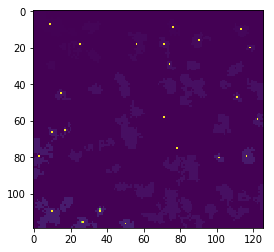

In [25]:
for elem in synapse_centroids:
    test[elem] = 255
    
plt.figure()
plt.imshow(test)
plt.show()

In [26]:
connected_components = {}
for z in range(synapse_labels.shape[0]):
    for y in range(synapse_labels.shape[1]):
        for x in range(synapse_labels.shape[2]):
            if (synapse_labels[z][y][x] in connected_components.keys()):
                connected_components[synapse_labels[z][y][x]].append((z, y, x))
            else:
                connected_components[synapse_labels[z][y][x]] = [(z, y, x)]

connected_components.pop(0)

[(0, 0, 10),
 (0, 0, 11),
 (0, 0, 12),
 (0, 0, 13),
 (0, 0, 14),
 (0, 0, 15),
 (0, 0, 16),
 (0, 0, 17),
 (0, 0, 18),
 (0, 0, 19),
 (0, 0, 20),
 (0, 0, 21),
 (0, 0, 22),
 (0, 0, 23),
 (0, 0, 24),
 (0, 0, 25),
 (0, 0, 26),
 (0, 0, 27),
 (0, 0, 28),
 (0, 0, 29),
 (0, 0, 30),
 (0, 0, 31),
 (0, 0, 32),
 (0, 0, 33),
 (0, 0, 34),
 (0, 0, 35),
 (0, 0, 36),
 (0, 0, 37),
 (0, 0, 38),
 (0, 0, 39),
 (0, 0, 40),
 (0, 0, 41),
 (0, 0, 42),
 (0, 0, 43),
 (0, 0, 44),
 (0, 0, 45),
 (0, 0, 46),
 (0, 0, 47),
 (0, 0, 48),
 (0, 0, 49),
 (0, 0, 50),
 (0, 0, 51),
 (0, 0, 52),
 (0, 0, 53),
 (0, 0, 54),
 (0, 0, 55),
 (0, 0, 56),
 (0, 0, 57),
 (0, 0, 58),
 (0, 0, 59),
 (0, 0, 60),
 (0, 0, 61),
 (0, 0, 62),
 (0, 0, 63),
 (0, 0, 64),
 (0, 0, 65),
 (0, 0, 66),
 (0, 0, 67),
 (0, 0, 68),
 (0, 0, 69),
 (0, 0, 70),
 (0, 0, 71),
 (0, 0, 72),
 (0, 0, 73),
 (0, 0, 74),
 (0, 0, 75),
 (0, 0, 76),
 (0, 0, 77),
 (0, 0, 78),
 (0, 0, 79),
 (0, 0, 80),
 (0, 0, 81),
 (0, 0, 82),
 (0, 0, 83),
 (0, 0, 84),
 (0, 0, 85),
 (0, 0, 86),

In [31]:
synapse_centroids = []
for key, value in connected_components.items():
    z, y, x = zip(*value)
    synapse_centroids.append((int(sum(z)/len(z)), int(sum(y)/len(y)), int(sum(x)/len(x))))
for elem in synapse_centroids:
    synapse_labels[elem] = 200

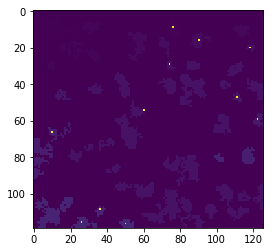

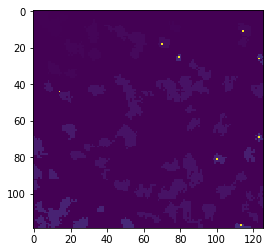

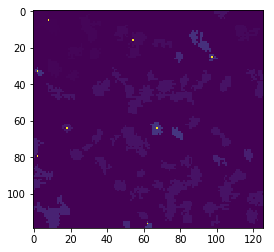

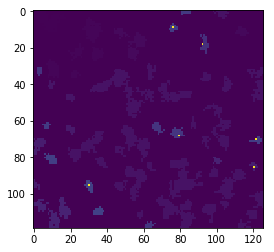

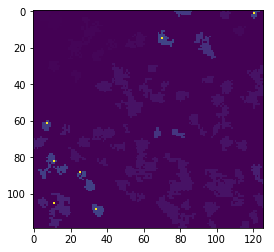

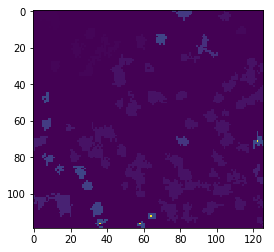

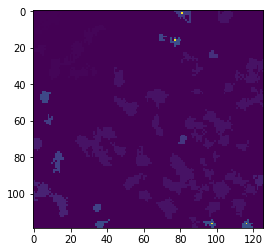

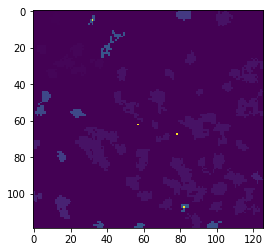

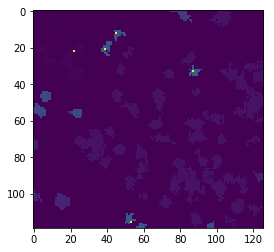

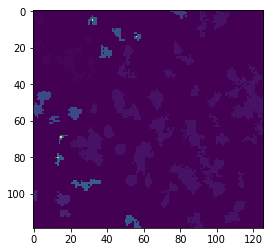

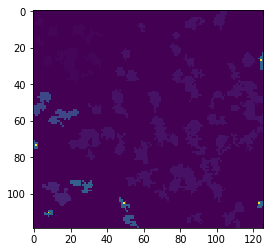

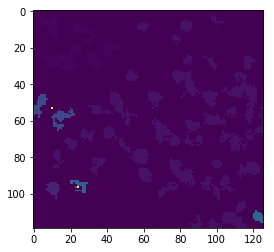

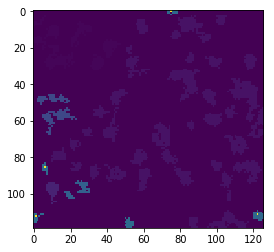

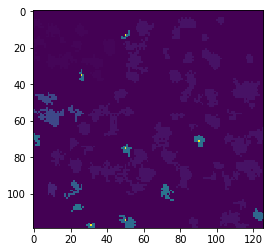

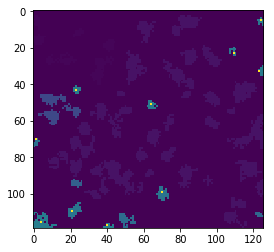

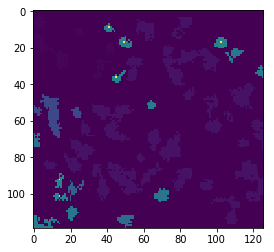

In [32]:
for i in range(synapse_labels.shape[0]):
    plt.figure()
    plt.imshow(synapse_labels[i])
    plt.show()

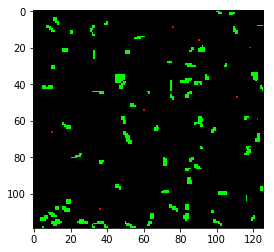

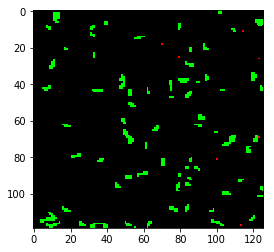

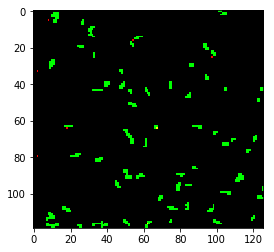

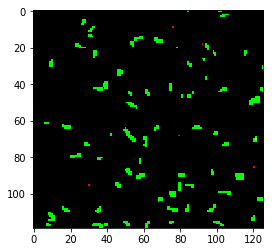

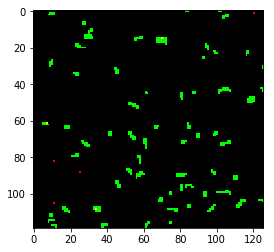

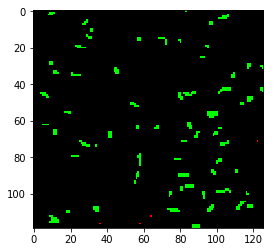

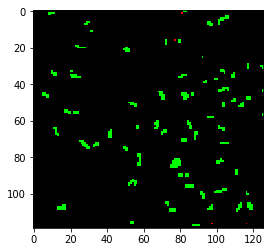

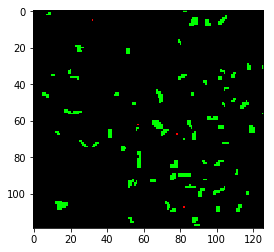

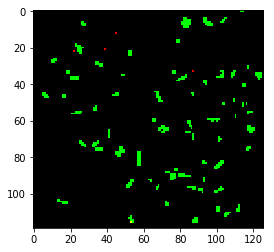

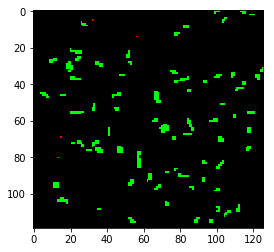

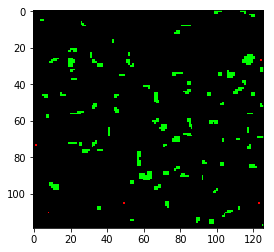

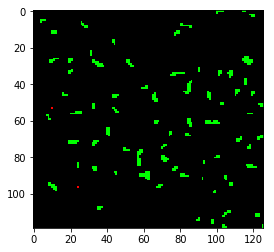

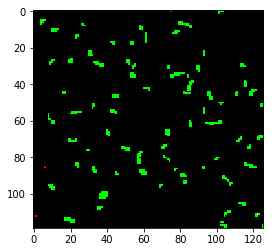

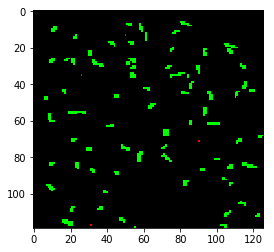

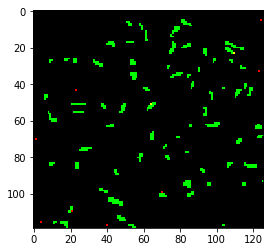

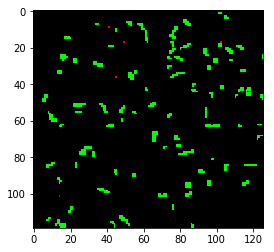

In [34]:
test = synapse_labels
test[np.where( test < 200 )] = 0
for idx, z_postproc in enumerate(full_postproc):
    plt.figure()
    img = make_overlap_img(test[idx], full_gt[idx])
    plt.imshow(img)
    plt.show()

In [38]:
def get_aggregate_sum(synapse_centroids, data):
    z_max, y_max, x_max = data["PSD95"].shape
    data_dictionary = dict((key, []) for key in data.keys())
    for centroid in synapse_centroids:
        z, y, x = centroid
        z_lower = z - 11
        z_upper = z + 11
        y_lower = y - 11
        y_upper = y + 11
        x_lower = x - 11
        x_upper = x + 11
        # prob a better way but w/e tired rn
        # ignore boundary synapses
        if z_lower < 0 or z_upper >= z_max:
            continue
        if y_lower < 0 or y_upper >= y_max:
            continue
        if x_lower < 0 or x_upper >= x_max:
            continue
        for key in data.keys():
            data_dictionary[key].append(np.sum(data[key][z_lower:z_upper, y_lower:y_upper, x_lower: x_upper]))
    return data_dictionary

data_dict = get_aggregate_sum(synapse_centroids, data)

In [41]:
for key in data_dict.keys():
    print(len(data_dict[key]))

20
20
20
20
20
20
20
20
20


In [45]:
print(list(data_dict.items()))

[('GAD2', [1604, 2107, 998, 1267, 2118, 1309, 1760, 2698, 1135, 968, 744, 812, 2047, 1952, 1089, 1389, 781, 1525, 1418, 1420]), ('GluN1', [2203, 2164, 1915, 2447, 2331, 1950, 2458, 2221, 1668, 1614, 1798, 1435, 2010, 1883, 1867, 2415, 1660, 2927, 2169, 2162]), ('synapsin', [1364, 2401, 1209, 879, 2043, 1527, 2072, 1771, 1589, 1416, 1215, 631, 1453, 1785, 1245, 767, 1840, 1325, 1675, 1214]), ('MBP', [1046, 0, 5715, 1394, 1242, 0, 2275, 1, 1742, 4163, 4052, 542, 215, 2139, 4981, 1203, 4343, 1079, 1310, 623]), ('annotation', [23635149, 68409675, 84914611, 4328407, 21352500, 83676478, 53213486, 45076966, 39265084, 76848603, 68163911, 56603718, 19837219, 59742384, 72579143, 17368178, 86452343, 5236532, 12027011, 16980086]), ('VGlut1', [2244, 1938, 2051, 2062, 2606, 1733, 1971, 1966, 1865, 1787, 1712, 1586, 1855, 1994, 1632, 2133, 1561, 3026, 1784, 1634]), ('Gephyrin', [1957, 1179, 1383, 1479, 1778, 1608, 1404, 1496, 1366, 1416, 1116, 1326, 1391, 1569, 1125, 1231, 1188, 1677, 1686, 1391]), (

In [51]:
import pandas as pd
chan, features = zip(*list(data_dict.items()))
print(len(chan))
print(len(features))

9
9


In [57]:
df = pd.DataFrame(data_dict)
print(df)


    GABA  GAD2  Gephyrin  GluN1   MBP  PSD95  VGlut1  annotation  synapsin
0   3126  1604      1957   2203  1046   1355    2244    23635149      1364
1   2505  2107      1179   2164     0   1731    1938    68409675      2401
2   1172   998      1383   1915  5715   1202    2051    84914611      1209
3   1953  1267      1479   2447  1394    923    2062     4328407       879
4   2619  2118      1778   2331  1242   1608    2606    21352500      2043
5    534  1309      1608   1950     0    964    1733    83676478      1527
6   1748  1760      1404   2458  2275   1771    1971    53213486      2072
7   2088  2698      1496   2221     1   1930    1966    45076966      1771
8   2375  1135      1366   1668  1742   1826    1865    39265084      1589
9   2084   968      1416   1614  4163   1184    1787    76848603      1416
10  2133   744      1116   1798  4052    873    1712    68163911      1215
11   637   812      1326   1435   542    917    1586    56603718       631
12  2461  2047      1391 

In [58]:
df.drop(["annotation"], axis = 1)

,GABA,GAD2,Gephyrin,GluN1,MBP,PSD95,VGlut1,synapsin
0,3126,1604,1957,2203,1046,1355,2244,1364
1,2505,2107,1179,2164,0,1731,1938,2401
2,1172,998,1383,1915,5715,1202,2051,1209
3,1953,1267,1479,2447,1394,923,2062,879
4,2619,2118,1778,2331,1242,1608,2606,2043
5,534,1309,1608,1950,0,964,1733,1527
6,1748,1760,1404,2458,2275,1771,1971,2072
7,2088,2698,1496,2221,1,1930,1966,1771
8,2375,1135,1366,1668,1742,1826,1865,1589
9,2084,968,1416,1614,4163,1184,1787,1416


In [59]:
df.to_csv("pymeda.csv", sep='\t')